![image](https://www.ewatercycle.org/img/logo.png)

# Case study 0: Hello worlds. Run two models on the same forcing data and compare output (discharge)
This notebooks demonstrates how to use models in eWaterCycle by showing how to run two different models for the same region and on the same forcing data (ERA5). This notebook also contains the steps for the preprocessing of the forcing data into model specific datasets using ESMValTool.

The models used in this notebook are:

- WFlow (details)
- LISFLood (details)


## Import statements
We'll be using the following modules

In [1]:
import os
import time
import xml.etree.ElementTree as ET
import shutil
from configparser import ConfigParser
from glob import glob
from pathlib import Path

from datetime import datetime
from cftime import num2date

import numpy as np
import pandas as pd
import xarray as xr

from ewatercycle.observation.grdc import get_grdc_data
from grpc4bmi.bmi_client_docker import BmiClientDocker

import hydrostats.visual as hv
import matplotlib.pyplot as plt

In [2]:
# This function takes an BMI model object, extracts variable and stores it 
# as an xarray object. For this to work, the variable does need to have a propper
# setup grid. See the BMI documentation on grids.

def var_to_xarray(model, variable):
    # Get grid properties from model (x = latitude !!)
    # could be speedup, lots of bmi calls are done here that dont change between updates
    shape = model.get_grid_shape(model.get_var_grid(variable))
    lat = model.get_grid_x(model.get_var_grid(variable))
    lon = model.get_grid_y(model.get_var_grid(variable))
    time = num2date(model.get_current_time(), model.get_time_units())

    # Get model data for variable at current timestep
    data = model.get_value(variable)
    data = np.reshape(data, shape)

    # Create xarray object
    da = xr.DataArray(data, 
                      coords = {'longitude': lon, 'latitude': lat, 'time': time}, 
                      dims = ['latitude', 'longitude'],
                      name = variable,
                      attrs = {'units': model.get_var_units(variable)}
                     )

    # Masked invalid values on return array:
    return da.where(da != -999)

### Directory settings

In [3]:
# The project home directory where data lives and output should be written
PROJECT_HOME = Path(os.path.abspath("/mnt/home/user42"))
DATA_HOME = Path(os.path.abspath("/mnt/data/examples/technical_paper"))

In [ ]:
# add a timestamped temp directory to the main tempdir
TEMP_DIR = SCRATCH / 'case0' / f"case0_temp_{time.strftime('%Y%m%d_%H%M%S')}"
TEMP_DIR.mkdir(parents=True, exist_ok=True)
print(TEMP_DIR)

### Experiment settings

In [ ]:
dataset = "ERA5"
catchment = "Merrimack"
PERIOD = {"start": datetime(2001, 1, 1), "end": datetime(2002, 1, 15)}

# time to read forcing files
start_year = PERIOD["start"].year
end_year = PERIOD["end"].year

### Model specific settings

#### WFlow

In [4]:
wflow_input_dir= str(DATA_HOME / 'wflow' / 'merrimack')
wflow_output_dir=str(PROJECT_HOME / 'case3' / 'output_wflow_test')
wflow_ini = str(DATA_HOME / 'wflow' / 'merrimack' / 'wflow_sbm_era5_test.ini')

#this file will be created by copying the ini file here
#TODO this should not be needed.
wflow_ini_with_timestamp = str(PROJECT_HOME / 'case3' / 'output_wflow_test' / ('wflow_sbm_era5_test_' + str(datetime.now()) + '.ini'))

#### LISFlood

In [ ]:
# esmvaltool input file names
vars = ["tas", "tasmax", "tasmin", "e", "sfcWind", "rsds"]

# lisvap input file names
lisflood_vars = [
    "TAvgMaps",
    "TMaxMaps",
    "TMinMaps",
    "EActMaps",
    "WindMaps",
    "RgdMaps",
]

# lisvap output files
lisvap_vars = ["e0", "es0", "et0"]
lisvap_vars_prefixs = ["PrefixE0", "PrefixES0", "PrefixET0"]
lisvap_maps = ["E0Maps", "ES0Maps", "ET0Maps"]

### Pre processing model forcing using ESMValTool

#### LISFlood

In [ ]:
# Make a dictionary for settings
maps = "/data/lisflood_input/Lisflood01degree_masked/maps_netcdf"
settings = {
    "CalendarDayStart": PERIOD["start"].strftime("%d/%m/%Y %H:%M"),
    "StepStart": PERIOD["start"].strftime("%d/%m/%Y %H:%M"),
    "StepEnd": PERIOD["end"].strftime("%d/%m/%Y %H:%M"),
    "PathOut": "/output",
    "PathBaseMapsIn": maps,
    "MaskMap": "/data/mask/model_mask",
    "PathMeteoIn": "/data/forcing",
}

# Open default setting file
lisvap_file = INPUT_DIR / "settings_templates" / "settings_lisvap.xml"
tree = ET.parse(str(lisvap_file))
root = tree.getroot()

for textvar in root.iter("textvar"):
    name = textvar.attrib["name"]

    # general settings
    for key, value in settings.items():
        if key in name:
            textvar.set("value", value)

    # lisvap input files
    for lisflood_var, var in zip(lisflood_vars, vars):
        if lisflood_var in name:
            filename = f"lisflood_{dataset}_{var}_{start_year}_{end_year}"
            textvar.set(
                "value", f"$(PathMeteoIn)/{filename}",
            )

    # lisvap output files
    for lisvap_vars_prefix, lisvap_var in zip(
        lisvap_vars_prefixs, lisvap_vars
    ):
        if lisvap_vars_prefix in name:
            textvar.set(
                "value",
                f"lisflood_{dataset}_{lisvap_var}_{start_year}_{end_year}",
            )

# Write to new setting file
lisvap_file = "lisvap_setting.xml"
tree.write(f"{TEMP_DIR}/{lisvap_file}")
print(f"The lisvap setting file is in {TEMP_DIR}/{lisvap_file}")

In [ ]:
#TODO: run ESMValTool to generate input for this experiment instead of it already being (magically) available.

In [5]:
#TODO this should not be needed.
shutil.copy(wflow_ini,wflow_ini_with_timestamp)

'/mnt/home/user42/case3/output_wflow_test/wflow_sbm_era5_test_2021-03-10 09:51:27.604337.ini'

In [6]:
# start up a container for PCRGlob for the reference run 
# and initialize using the setting file
wflow = BmiClientDocker(image='ewatercycle/wflow-grpc4bmi:latest', image_port=55555,

                   input_dir=wflow_input_dir,

                   output_dir=wflow_output_dir)

 

wflow.initialize(wflow_ini_with_timestamp)

In [7]:
wflow_output = []

In [10]:
wflow.get_output_var_names()

('SurfaceRunoff',)

In [11]:
#TODO (Rolf) this should be done using propper time from the experiment settings

#run the reference model for one timestep, store the output
for i in range(30):
    print(i)
    print(wflow.get_value('SurfaceRunoff').max())
    print(wflow.get_value('SurfaceRunoff').min())
    wflow.update()
    wflow_output.append(var_to_xarray(wflow, variable='SurfaceRunoff'))

0
2.2190279216708916e+35
-111852054904832.0
1
18916.611328125
0.0
2
16359.7548828125
0.0
3
11673.712890625
0.0
4
8335.5087890625
0.0
5
5920.576171875
0.0
6
4298.24169921875
0.0
7
3208.436279296875
0.0
8
2506.794921875
0.0
9
2044.8973388671875
0.0
10
1656.5982666015625
0.0
11
1407.8919677734375
0.0
12
1200.6568603515625
0.0
13
1024.837646484375
0.0
14
892.3717041015625
0.0
15
795.0549926757812
0.0
16
728.9182739257812
0.0
17
640.0759887695312
0.0
18
592.2872924804688
0.0
19
510.9825744628906
0.0
20
479.3186950683594
0.0
21
441.7477111816406
0.0
22
411.2637939453125
0.0
23
378.0399169921875
0.0
24
362.9239807128906
0.0
25
373.7604675292969
0.0
26
290.06976318359375
0.0
27
232.59771728515625
0.0
28
199.12753295898438
0.0
29
178.8760528564453
0.0


In [15]:
wflow.finalize()
del wflow

In [13]:
data  = xr.concat(wflow_output, dim='time')

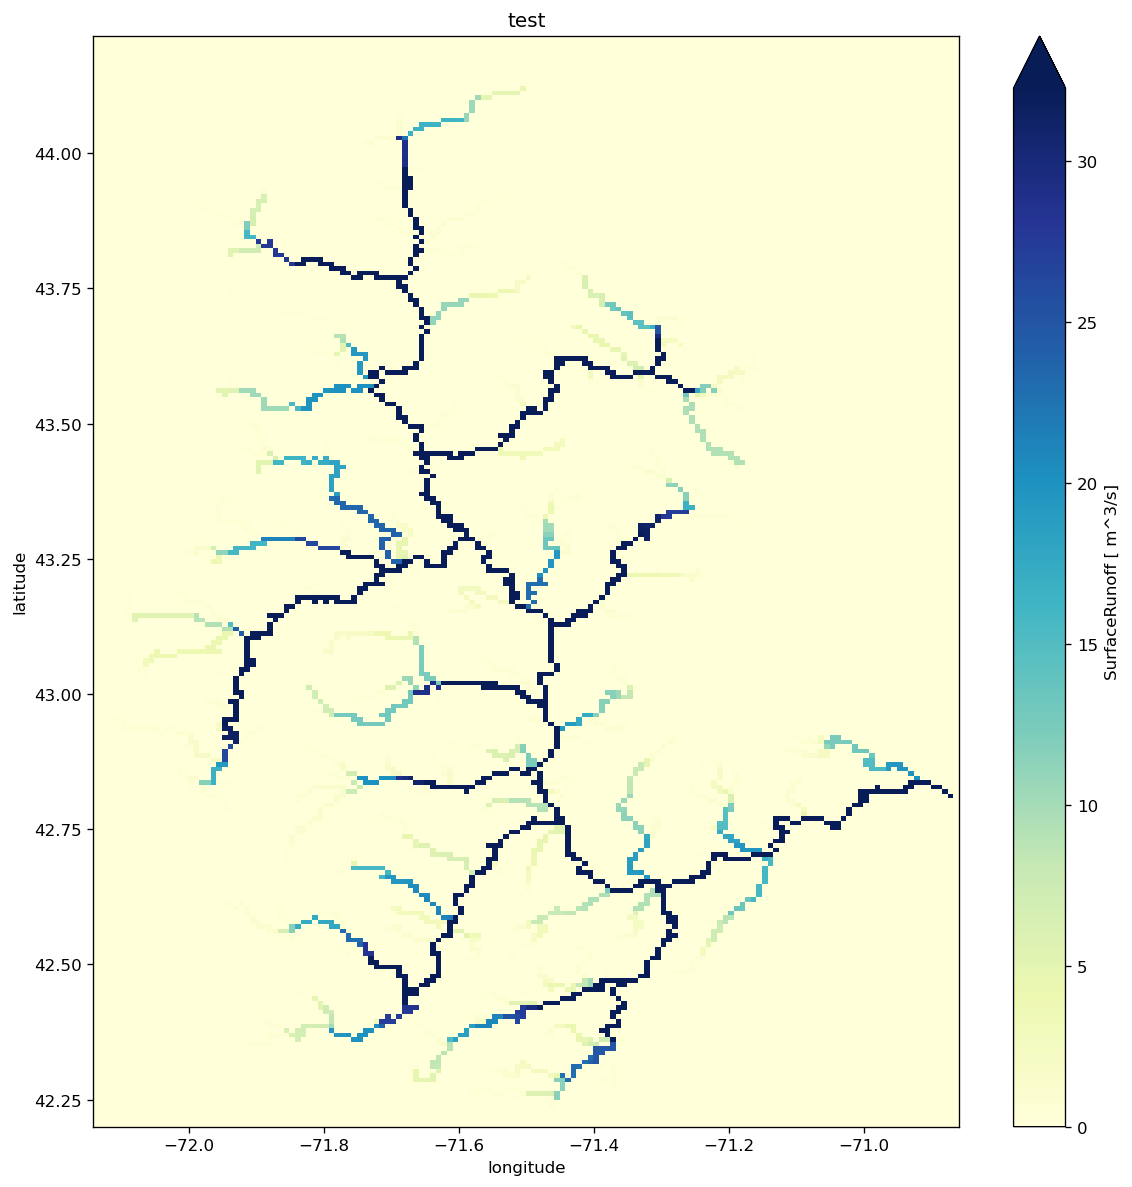

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10), dpi=120)

data.isel(time=10).plot(ax=axs, cmap='YlGnBu', robust=True)
axs.set_title('test')
plt.tight_layout()